In [ ]:
%config IPCompleter.greedy=True

In [1]:
import sys
import os
import pandas as pd
sys.path.append("..") # relative path to module toolkit

In [2]:
#from keras.applications import ResNet50
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras_preprocessing.image import ImageDataGenerator
from toolkit import getLabelsFromDir, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# setup
batch_size = 16
val_dir = "../../images/images_genus/val/"
val__images = 3454 # images in val_dir
datasetDir = "images_genus/"
saved_model = "resnet50_first.h5"
results_file = "results.csv" # file to save results to

In [ ]:
labels = getLabelsFromDir(val_dir)
val_datagen = ImageDataGenerator(rescale=1./255.)
validation_steps = int(val_images/batch_size) + 1

In [4]:
model = load_model(saved_model)

In [5]:
val_generator = val_datagen.flow_from_directory(val_dir,
                                                    classes=labels,
                                                    class_mode="categorical",
                                                    batch_size=batch_size,
                                                    color_mode='rgb',
                                                    target_size=(224, 224),
                                                    shuffle=False,
                                                    seed=1)

Found 3454 images belonging to 44 classes.


In [6]:
Y_pred = model.predict_generator(val_generator, steps=validation_steps, verbose=1)

216/216 [==============================] - 21s 98ms/step


In [7]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred3 = [y[-3:] for y in np.argsort(Y_pred, axis=1)] 

In [8]:
print(classification_report(val_generator.classes, y_pred, target_names=labels))

              precision    recall  f1-score   support

  Creophilus       0.75      1.00      0.86         9
    Velleius       0.71      1.00      0.83         5
   Megalinus       0.67      0.57      0.62         7
Dinothenarus       0.80      1.00      0.89         8
      Sunius       0.91      1.00      0.95        41
 Platydracus       1.00      0.86      0.93        22
     Atrecus       1.00      1.00      1.00        14
  Paederidus       0.98      1.00      0.99        49
    Achenium       1.00      1.00      1.00         8
      Othius       1.00      0.90      0.95        40
 Staphylinus       0.89      1.00      0.94        17
 Ontholestes       0.86      1.00      0.92        18
     Tasgius       0.94      0.91      0.92        32
     Rugilus       1.00      0.97      0.99       139
  Gyrohypnus       0.85      0.90      0.88        51
  Leptacinus       0.89      0.93      0.91        42
  Neobisnius       1.00      0.84      0.91        37
     Gabrius       0.91    

Normalized confusion matrix
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.57142857 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.92307692 0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.92682927]]


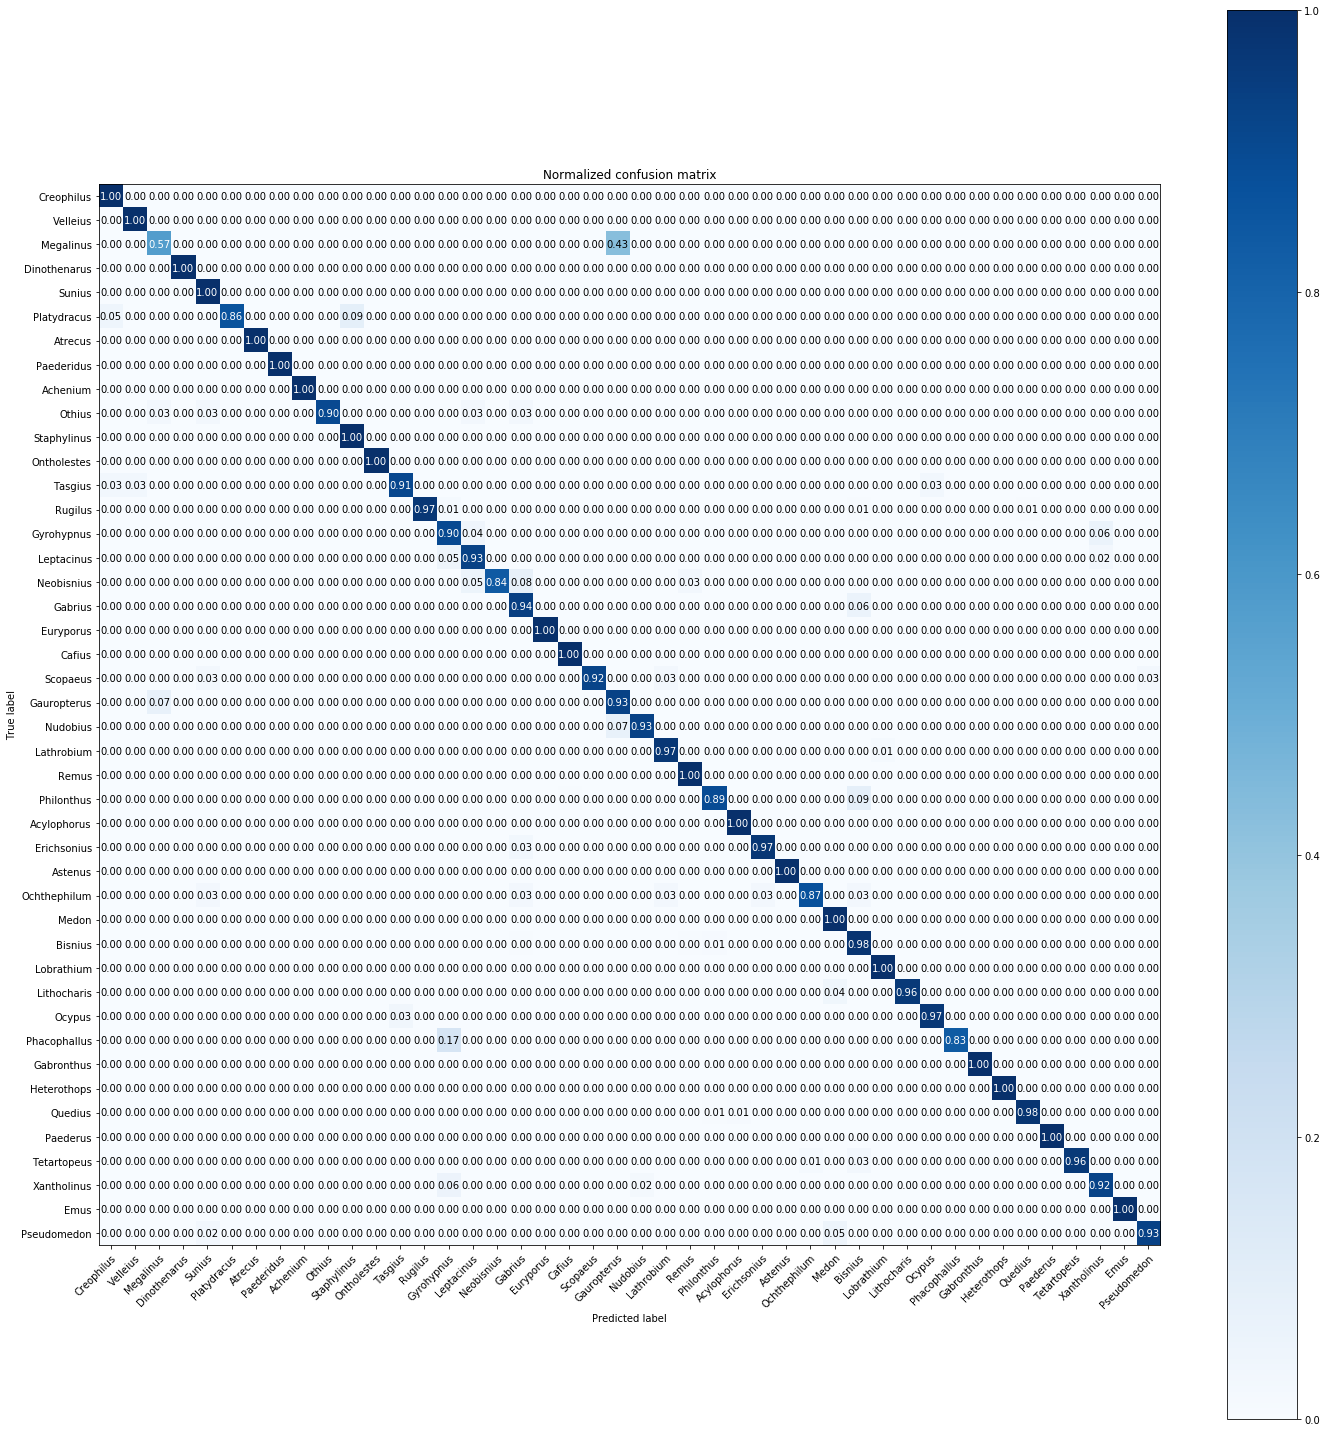

In [9]:
y_true = val_generator.classes
matplotlib.rcParams['figure.figsize'] = [20, 20]
plot_confusion_matrix(y_true, y_pred, np.array(labels), normalize=True)

In [10]:
labels = (val_generator.class_indices) # dict of label:index
labels = dict((i,l) for l,i in labels.items()) # dict of index:label

In [11]:
# create pd.dataframe and save predictions to .csv
filenames=[datasetDir + name for name in val_generator.filenames]
y_pred_labels = [labels[y] for y in y_pred]
y_true_labels = [labels[y] for y in y_true]
y_pred3_labels = []
for i,top3 in enumerate(y_pred3):
    l = []
    for top in top3:
        l.append((labels[top], Y_pred[i][top]))
    y_pred3_labels.append(l)

results=pd.DataFrame({"Filename":filenames,
                      "Label":y_true_labels,
                      "Prediction1":y_pred_labels,
                      "Prediction3":y_pred3_labels})
results.to_csv(results_file,index=True)